In [ ]:
! pip install -U -q transformers
! pip install -q datasets sentence-transformers evaluate
! pip install -q accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 6.0 MB/s e

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import time
import re
from tqdm import notebook
import json

import seaborn as sns
import matplotlib.pyplot as plt

import os
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import AutoModel
from transformers import AutoConfig
from transformers import get_cosine_schedule_with_warmup

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import r2_score

from datasets import Dataset
import evaluate

from sentence_transformers import SentenceTransformer, models, util

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback, TextClassificationPipeline

## Setting random seeed.

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

In [ ]:
SEED = 97
seed_everything(SEED)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: ', device.type)

Device:  cuda


# Dataset load and process.

1. Load selected dataset for variability analysis.
2. Split into train, test and val sets.
3. Get sentence embeddings for each train sample (try sampling for each label separately).

Task - write a method for loading the dataset

In [ ]:
def get_qnli_dataset_dfs(test_size=0.1):
  dataset = load_dataset("glue", "qnli")

  # Access the train split of the dataset
  df = dataset["train"].to_pandas().dropna()
  test_df = dataset["validation"].to_pandas().dropna()

  X_train, X_val, y_train, y_val = train_test_split(df[['question', 'sentence']], df.label, test_size=test_size, random_state=SEED, stratify=df.label)

  train_df = X_train[['question', 'sentence']].copy().reset_index(drop=True)
  val_df = X_val[['question', 'sentence']].copy().reset_index(drop=True)

  train_df['label'] = y_train.tolist()
  val_df['label'] = y_val.tolist()

  test_df = test_df[['question', 'sentence', 'label']]

  train_df.columns = ['sentence1', 'sentence2', 'label']
  val_df.columns = ['sentence1', 'sentence2', 'label']
  test_df.columns = ['sentence1', 'sentence2', 'label']

  return train_df, val_df, test_df

In [ ]:
def get_anli_dataset_dfs(test_size=0.1):
  dataset = load_dataset("anli")

  # Access the train split of the dataset
  df = dataset["train_r3"].to_pandas().dropna()
  test_df = dataset["dev_r3"].to_pandas().dropna()

  X_train, X_val, y_train, y_val = train_test_split(df[['premise', 'hypothesis']], df.label, test_size=test_size, random_state=SEED, stratify=df.label)

  train_df = X_train[['premise', 'hypothesis']].copy().reset_index(drop=True)
  val_df = X_val[['premise', 'hypothesis']].copy().reset_index(drop=True)

  train_df['label'] = y_train.tolist()
  val_df['label'] = y_val.tolist()

  test_df = test_df[['premise', 'hypothesis', 'label']]

  train_df.columns = ['sentence1', 'sentence2', 'label']
  val_df.columns = ['sentence1', 'sentence2', 'label']
  test_df.columns = ['sentence1', 'sentence2', 'label']

  return train_df, val_df, test_df

In [ ]:
def get_sst2_dataset_dfs(test_size=0.1):
  dataset = load_dataset('sst2', 'binary')
  df = dataset['train'].to_pandas().dropna()

  X_train, X_temp, y_train, y_temp = train_test_split(df[['idx', 'sentence']], df.label, test_size=test_size*2, random_state=SEED, stratify=df.label)
  X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp)

  train_df = X_train[['sentence']].copy().reset_index(drop=True)
  val_df = X_val[['sentence']].copy().reset_index(drop=True)
  test_df = X_test[['sentence']].copy().reset_index(drop=True)

  train_df['label'] = y_train.tolist()
  val_df['label'] = y_val.tolist()
  test_df['label'] = y_test.tolist()

  return train_df, val_df, test_df

In [ ]:
def get_imdb_dataset_dfs():
  dataset = load_dataset('imdb')
  train_df = dataset['train'].to_pandas().dropna()
  train_df.columns = ['sentence', 'label']

  test_df = dataset['test'].to_pandas().dropna()
  test_df.columns = ['sentence', 'label']

  return train_df, test_df

# Load Embeddings model

In [ ]:
embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2', device=device)

In [ ]:
def get_embeddings(data):
    return embedder.encode(data, convert_to_tensor=True)

# Variance Utilities

In [ ]:
# embeddings -> (25000, 384) -> (25000, 100)
def get_self_variance(embeddings, n_components=100):
  pca = PCA(n_components=n_components)
  principal_components = pca.fit_transform(embeddings)

  # how much of the variance or information you were able to retain

  explained_variance_ratio = pca.explained_variance_ratio_
  # explained_variance_ratio = size -> (100, ) # sorted in descending order
  return np.sum(explained_variance_ratio), explained_variance_ratio

In [ ]:
# embeddings -> (25000, 384)
def get_variance_measures(embeddings, step=10, n_components=100):
  rng = np.random.default_rng()

  r2_values = []
  self_exp_vars = []
  subset_sizes = []
  rand_subsets_indices = []
  indices = np.arange(embeddings.shape[0])

  step_size = len(embeddings)//step

  for n in notebook.tqdm(range(step_size, len(embeddings)+1, step_size)):
    subset_sizes.append(n)
    pca = PCA(n_components=n_components)

    subset_indices = rng.choice(indices, n, replace=False)
    rand_subsets_indices.append(subset_indices)

    # 1st iteration -> (2500, 384) pca on the subset
    principal_components = pca.fit_transform(embeddings[subset_indices])

    explained_variance_ratio = pca.explained_variance_ratio_

    expl_var = np.sum(explained_variance_ratio)
    self_exp_vars.append(expl_var)

    # pca.transform(embeddings) -> (25000, 100)
    # pca.inverse_transform(pca.transform(embeddings)) - (25000, 100) -> (25000, 384)

    r2_values.append(r2_score(embeddings, pca.inverse_transform(pca.transform(embeddings)), multioutput='variance_weighted'))

  return self_exp_vars, r2_values, subset_sizes, rand_subsets_indices

In [ ]:
def get_variance_measures_class(embeddings, indices, step=10, n_components=100):
  rng = np.random.default_rng()

  r2_values = []
  self_exp_vars = []
  subset_sizes = []
  rand_subsets_indices = []

  step_size = len(indices)//step

  for n in notebook.tqdm(range(step_size, len(indices)+1, step_size)):
    subset_sizes.append(n)
    pca = PCA(n_components=n_components)

    subset_indices = rng.choice(indices, n, replace=False)
    rand_subsets_indices.append(subset_indices)

    principal_components = pca.fit_transform(embeddings[subset_indices])

    explained_variance_ratio = pca.explained_variance_ratio_

    expl_var = np.sum(explained_variance_ratio)
    self_exp_vars.append(expl_var)

    r2_values.append(r2_score(embeddings[indices], pca.inverse_transform(pca.transform(embeddings[indices])), multioutput='variance_weighted'))

  return self_exp_vars, r2_values, subset_sizes, rand_subsets_indices

In [ ]:
def plot_variance_measure(subset_sizes, r2_values, full_set_var):
  graph = sns.lineplot(x=subset_sizes, y=r2_values, marker="o")
  graph.axhline(full_set_var, color='red')
  plt.show()

In [ ]:
def plot_variance_measure_extra(subset_sizes, r2_values, full_set_var, self_expl_vars):
  r2_values.insert(0, 0)
  subset_sizes.insert(0, 0)
  graph = sns.lineplot(x=subset_sizes, y=r2_values, marker="o")
  sns.lineplot(x=subset_sizes, y=self_expl_vars, marker="o")
  graph.axhline(full_set_var, color='red')
  plt.show()

# Variance Analysis

## ANLI

In [ ]:
train_df_anli, val_df_anli, test_df_anli = get_anli_dataset_dfs()

Generating train_r1 split:   0%|          | 0/16946 [00:00<?, ? examples/s]

Generating dev_r1 split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test_r1 split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating train_r2 split:   0%|          | 0/45460 [00:00<?, ? examples/s]

Generating dev_r2 split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test_r2 split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating train_r3 split:   0%|          | 0/100459 [00:00<?, ? examples/s]

Generating dev_r3 split:   0%|          | 0/1200 [00:00<?, ? examples/s]

Generating test_r3 split:   0%|          | 0/1200 [00:00<?, ? examples/s]

<Axes: >

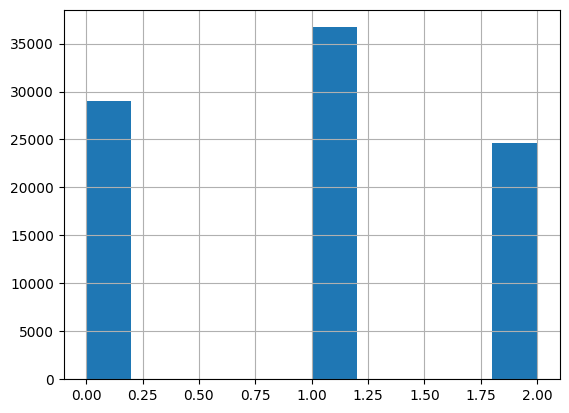

In [ ]:
train_df_anli.label.hist()

### Separating Labels for Variance Ananlysis

In [ ]:
train_df_anli_0 = train_df_anli[train_df_anli['label'] == 0]
train_df_anli_1 = train_df_anli[train_df_anli['label'] == 1]
train_df_anli_2 = train_df_anli[train_df_anli['label'] == 2]

class_anli_0_indices = train_df_anli[train_df_anli['label'] == 0].index.tolist()
class_anli_1_indices = train_df_anli[train_df_anli['label'] == 1].index.tolist()
class_anli_2_indices = train_df_anli[train_df_anli['label'] == 2].index.tolist()

sentences_cat = np.add.reduce(train_df_anli[['sentence1', 'sentence2']], axis=1)

In [ ]:
len(class_anli_0_indices), len(class_anli_1_indices), len(class_anli_2_indices)

(29063, 36700, 24650)

In [ ]:
temp_list = list(class_anli_0_indices)
temp_list.extend(class_anli_1_indices)
temp_list.extend(class_anli_2_indices)
len(set(temp_list))

90413

In [ ]:
%%time
sentence_embeddings_anli = get_embeddings(sentences_cat.values).detach().cpu().numpy()

CPU times: user 1h 15min 47s, sys: 1min 16s, total: 1h 17min 4s
Wall time: 1h 17min 22s


  0%|          | 0/10 [00:00<?, ?it/s]

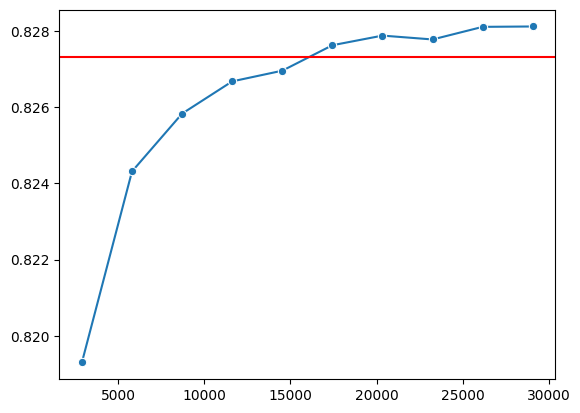

In [ ]:
full_set_var_anli_0, explained_variance_ratio_anli_0 = get_self_variance(sentence_embeddings_anli[class_anli_0_indices])
self_expl_vars_anli_0, r2_values_anli_0, subset_sizes_anli_0, rand_subset_indices_anli_0 = get_variance_measures_class(sentence_embeddings_anli, class_anli_0_indices)
plot_variance_measure(subset_sizes_anli_0, r2_values_anli_0, full_set_var_anli_0)

  0%|          | 0/10 [00:00<?, ?it/s]

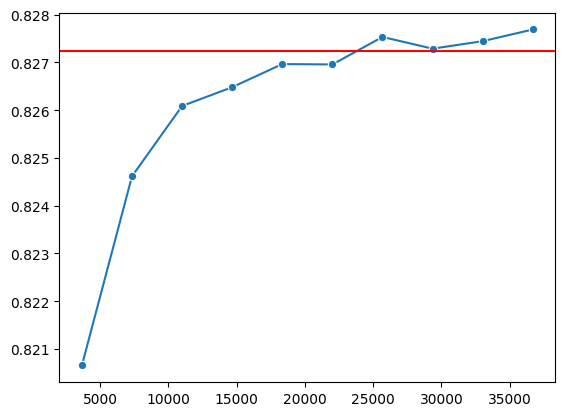

In [ ]:
full_set_var_anli_1, explained_variance_ratio_anli_1 = get_self_variance(sentence_embeddings_anli[class_anli_1_indices])
self_expl_vars_anli_1, r2_values_anli_1, subset_sizes_anli_1, rand_subset_indices_anli_1 = get_variance_measures_class(sentence_embeddings_anli, class_anli_1_indices)
plot_variance_measure(subset_sizes_anli_1, r2_values_anli_1, full_set_var_anli_1)

  0%|          | 0/10 [00:00<?, ?it/s]

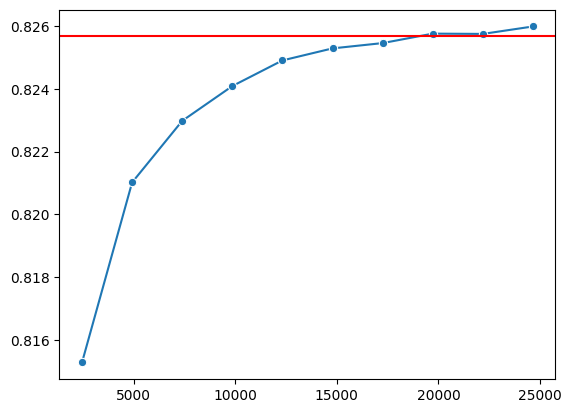

In [ ]:
full_set_var_anli_2, explained_variance_ratio_anli_2 = get_self_variance(sentence_embeddings_anli[class_anli_2_indices])
self_expl_vars_anli_2, r2_values_anli_2, subset_sizes_anli_2, rand_subset_indices_anli_2 = get_variance_measures_class(sentence_embeddings_anli, class_anli_2_indices)
plot_variance_measure(subset_sizes_anli_2, r2_values_anli_2, full_set_var_anli_2)

In [ ]:
subset_sizes_anli_0, subset_sizes_anli_1, subset_sizes_anli_2

([2906, 5812, 8718, 11624, 14530, 17436, 20342, 23248, 26154, 29060],
 [3670, 7340, 11010, 14680, 18350, 22020, 25690, 29360, 33030, 36700],
 [2465, 4930, 7395, 9860, 12325, 14790, 17255, 19720, 22185, 24650])

In [ ]:
rand_subset_indices_anli = []
for i in range(len(rand_subset_indices_anli_0)):
  indices = np.concatenate((rand_subset_indices_anli_0[i], rand_subset_indices_anli_1[i], rand_subset_indices_anli_2[i]))
  rand_subset_indices_anli.append(indices)

  print(len(indices))

9041
18082
27123
36164
45205
54246
63287
72328
81369
90410


# Modelling

In [ ]:
MODEL_NAME = "bert-base-uncased"
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 32
SAVE_MODEL_PATH = "/content/drive/MyDrive/Representative Subset/Models"
SAVE_LOGS_PATH = "/content/drive/MyDrive/Representative Subset/Logs"
LEARNING_RATE = 5e-5
EPOCHS = 5

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
# Funtion to tokenize data
def tokenize_dataset(data):
    return tokenizer(data["sentence1"],
                     data["sentence2"],
                     max_length=MAX_LEN,
                     truncation=True,
                     padding="max_length"
                     )

In [ ]:
# Function to compute the metric
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    logits, labels = eval_pred
    # probabilities = tf.nn.softmax(logits)
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
# Define model
def model_init():
  return AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

In [ ]:
def get_hf_dataset(df):
  data = Dataset.from_pandas(df)
  dataset = data.map(tokenize_dataset)
  return dataset

In [ ]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir=SAVE_MODEL_PATH,
    logging_dir=SAVE_LOGS_PATH,
    logging_strategy='epoch',
    logging_steps=100,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    seed=SEED,
    save_strategy='epoch',
    save_steps=100,
    evaluation_strategy='epoch',
    eval_steps=100,
    load_best_model_at_end=True
)

In [ ]:
DATASET_NAME = "ANLI_R3"

In [ ]:
def train_on_subsets(subset_indices_list, train_df, test_df, val_df=None):

  sizes = []
  test_accuracies = []
  test_losses = []

  test_dataset = get_hf_dataset(test_df)
  if val_df is not None:
    val_dataset = get_hf_dataset(val_df)
  else:
    val_dataset = get_hf_dataset(test_df.copy())

  for i in range(4, len(subset_indices_list)):
    subset_indices = subset_indices_list[i]
    subset_train_df = train_df.loc[subset_indices].reset_index(drop=True)
    subset_train_df.columns = ['sentence1', 'sentence2', 'label']

    train_dataset = get_hf_dataset(subset_train_df)

    len(train_dataset)

    trainer = Trainer(
      model_init=model_init,
      args=training_args,
      train_dataset=train_dataset,
      eval_dataset=val_dataset,
      compute_metrics=compute_metrics,
      callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
    )

    trainer.train()

    test_predict_result = trainer.predict(test_dataset)

    test_accuracies.append(test_predict_result.metrics['test_accuracy'])
    test_losses.append(test_predict_result.metrics['test_loss'])

    print(f"For subset: {len(subset_indices)} -> Test Accuracy: {test_predict_result.metrics['test_accuracy']}, Test Loss: {test_predict_result.metrics['test_loss']}\n")

    sizes.append(len(subset_indices))
    trainer.save_model(f"/content/drive/MyDrive/CS567-ML/{DATASET_NAME}/Subset-Models/model-{len(subset_indices)}")

  return sizes, test_accuracies, test_losses

In [ ]:
def plot_stats(subset_sizes, test_accuracies, test_losses):
  sns.lineplot(x=subset_sizes, y=test_accuracies, marker="o")
  plt.show()

In [ ]:
import os

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
sizes, test_accuracies, test_losses = train_on_subsets(rand_subset_indices_anli, train_df_anli, test_df_anli, val_df_anli)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/10046 [00:00<?, ? examples/s]

Map:   0%|          | 0/45205 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.716400,0.588221,0.761696
2,0.394100,0.584341,0.780311
3,0.182900,0.728294,0.783695


For subset: 45205 -> Test Accuracy: 0.4608333333333333, Test Loss: 1.480241298675537



Map:   0%|          | 0/54246 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.697600,0.559860,0.772447
2,0.381900,0.598575,0.785785


For subset: 54246 -> Test Accuracy: 0.445, Test Loss: 1.2245759963989258



Map:   0%|          | 0/63287 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.686200,0.578433,0.770854
2,0.372700,0.567676,0.797432
3,0.180400,0.679834,0.802708


For subset: 63287 -> Test Accuracy: 0.4625, Test Loss: 1.6270756721496582



Map:   0%|          | 0/72328 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.673500,0.537788,0.787079
2,0.369900,0.579534,0.802110


For subset: 72328 -> Test Accuracy: 0.45666666666666667, Test Loss: 1.2881805896759033



Map:   0%|          | 0/81369 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.665800,0.535072,0.789269
2,0.368400,0.555779,0.804201


For subset: 81369 -> Test Accuracy: 0.445, Test Loss: 1.2840900421142578



Map:   0%|          | 0/90410 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.649900,0.530016,0.795341
2,0.355200,0.504108,0.815051
3,0.178300,0.630672,0.816544


For subset: 90410 -> Test Accuracy: 0.4508333333333333, Test Loss: 1.5050774812698364



In [ ]:
import gc

In [ ]:
eval_results = []
test_dataset = get_hf_dataset(test_df_anli)
for indices in rand_subset_indices_anli:
  size = len(indices)
  model = AutoModelForSequenceClassification.from_pretrained(f"/content/drive/MyDrive/CS567-ML/{DATASET_NAME}/Subset-Models/model-{size}").to(device)
  trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
  )

  # Evaluate the model
  eval_result = trainer.evaluate(eval_dataset=test_dataset)
  print(eval_result)
  eval_results.append(eval_result)

  del model
  gc.collect()

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

{'eval_loss': 1.1931281089782715, 'eval_accuracy': 0.4166666666666667, 'eval_runtime': 16.865, 'eval_samples_per_second': 71.153, 'eval_steps_per_second': 2.253}


{'eval_loss': 1.3332561254501343, 'eval_accuracy': 0.4266666666666667, 'eval_runtime': 16.8848, 'eval_samples_per_second': 71.07, 'eval_steps_per_second': 2.251}


{'eval_loss': 1.4984503984451294, 'eval_accuracy': 0.4625, 'eval_runtime': 17.1402, 'eval_samples_per_second': 70.011, 'eval_steps_per_second': 2.217}


{'eval_loss': 1.5245168209075928, 'eval_accuracy': 0.44916666666666666, 'eval_runtime': 17.1247, 'eval_samples_per_second': 70.074, 'eval_steps_per_second': 2.219}


{'eval_loss': 1.480241298675537, 'eval_accuracy': 0.4608333333333333, 'eval_runtime': 17.3167, 'eval_samples_per_second': 69.297, 'eval_steps_per_second': 2.194}


{'eval_loss': 1.2245759963989258, 'eval_accuracy': 0.445, 'eval_runtime': 17.4091, 'eval_samples_per_second': 68.93, 'eval_steps_per_second': 2.183}


{'eval_loss': 1.6270756721496582, 'eval_accuracy': 0.4625, 'eval_runtime': 17.5987, 'eval_samples_per_second': 68.187, 'eval_steps_per_second': 2.159}


{'eval_loss': 1.2881805896759033, 'eval_accuracy': 0.45666666666666667, 'eval_runtime': 17.7636, 'eval_samples_per_second': 67.554, 'eval_steps_per_second': 2.139}


{'eval_loss': 1.2840900421142578, 'eval_accuracy': 0.445, 'eval_runtime': 17.8968, 'eval_samples_per_second': 67.051, 'eval_steps_per_second': 2.123}


{'eval_loss': 1.5050774812698364, 'eval_accuracy': 0.4508333333333333, 'eval_runtime': 17.928, 'eval_samples_per_second': 66.934, 'eval_steps_per_second': 2.12}


In [ ]:
test_accuracies = [result['eval_accuracy'] for result in eval_results]
test_losses = [result['eval_loss'] for result in eval_results]
sizes = [len(indices) for indices in rand_subset_indices_anli]

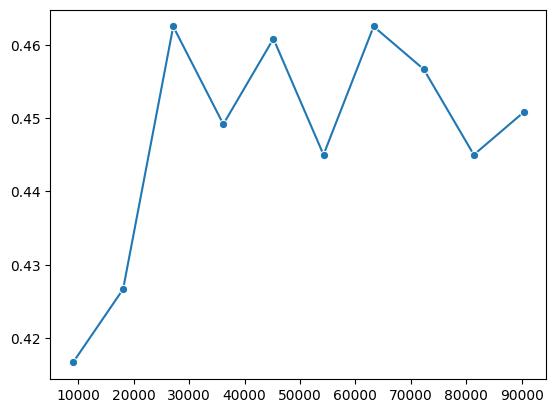

In [ ]:
plot_stats(sizes, test_accuracies, test_losses)

In [ ]:
test_accuracies

[0.4166666666666667,
 0.4266666666666667,
 0.4625,
 0.44916666666666666,
 0.4608333333333333,
 0.445,
 0.4625,
 0.45666666666666667,
 0.445,
 0.4508333333333333]

In [ ]:
test_losses

[1.1931281089782715,
 1.3332561254501343,
 1.4984503984451294,
 1.5245168209075928,
 1.480241298675537,
 1.2245759963989258,
 1.6270756721496582,
 1.2881805896759033,
 1.2840900421142578,
 1.5050774812698364]

In [ ]:
def save_metrics(filePath, variance_metrics, modelling_metrics):
  metrics = {'variance_metrics': variance_metrics, 'modelling_metrics': modelling_metrics}
  with open(filePath, "w") as outfile:
      json.dump(metrics, outfile)

In [ ]:
variance_metrics_anli_0 = {
    'full_set_var_sum': full_set_var_anli_0.astype(float),
    'full_set_var_values': [val.astype(float) for val in explained_variance_ratio_anli_0],
    'subsets_self_expl_vars': [val.astype(float) for val in self_expl_vars_anli_0],
    'r2_values': r2_values_anli_0,
    'subset_sizes': subset_sizes_anli_0
}
modelling_metrics_anli = {
    'subset_size': sizes,
    'test_accuracies': test_accuracies,
    'test_losses': test_losses
}
save_metrics(f"/content/drive/MyDrive/CS567-ML/{DATASET_NAME}/run-metrics-0.json", variance_metrics_anli_0, modelling_metrics_anli)

In [ ]:
variance_metrics_anli_1 = {
    'full_set_var_sum': full_set_var_anli_1.astype(float),
    'full_set_var_values': [val.astype(float) for val in explained_variance_ratio_anli_1],
    'subsets_self_expl_vars': [val.astype(float) for val in self_expl_vars_anli_1],
    'r2_values': r2_values_anli_1,
    'subset_sizes': subset_sizes_anli_1
}
save_metrics(f"/content/drive/MyDrive/CS567-ML/{DATASET_NAME}/run-metrics-1.json", variance_metrics_anli_1, modelling_metrics_anli)

In [ ]:
variance_metrics_anli_2 = {
    'full_set_var_sum': full_set_var_anli_2.astype(float),
    'full_set_var_values': [val.astype(float) for val in explained_variance_ratio_anli_2],
    'subsets_self_expl_vars': [val.astype(float) for val in self_expl_vars_anli_2],
    'r2_values': r2_values_anli_2,
    'subset_sizes': subset_sizes_anli_2
}
save_metrics(f"/content/drive/MyDrive/CS567-ML/{DATASET_NAME}/run-metrics-2.json", variance_metrics_anli_2, modelling_metrics_anli)